# PMI Case Study 3 - Nelson G. C. Guimaraes

The present notebook shows presents the the analysis requested to assess the problem of POS performance.

## Objective
Find what kind of surroundings and amenities lead to top performance for POS?

In [1]:
#Importing the libraries that will be used
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import json
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
import copy
import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

In [2]:
#Read one of the datasets
sales_granular = pd.read_csv("Data/UseCase_3_Datasets/sales_granular.csv")
sales_granular.set_index(sales_granular["store_code"].values,inplace=True)
sales_granular.drop("store_code", axis=1, inplace=True)
sales_granular_original_columns = sales_granular.columns
sales_granular = sales_granular.abs()

One of the datasets represent the sales for 906 stores, where each column represent a time stamp for sale volume

In [3]:
#Checking the dimensions of the dataset
sales_granular.shape

(906, 11936)

We can see that for any moment that no sales were made a NaN value is assigned, we will fill it with all zeros. It would be interesting to know when the first sale happened for each store, so we create a variable that will store how many days have passed since the first sale

In [4]:
sales_granular.head

<bound method DataFrame.head of        8/3/15 9:00  8/3/15 10:00  8/3/15 11:00  8/3/15 12:00  8/3/15 13:00  \
10055          NaN           NaN           NaN           NaN           NaN   
10077          NaN           NaN           NaN           NaN           NaN   
10079          NaN           NaN           NaN           NaN           NaN   
10081          NaN           NaN           NaN           NaN           NaN   
10085          NaN           NaN           NaN           NaN           NaN   
10086          NaN           NaN           NaN           NaN           NaN   
10111          NaN           NaN           NaN           NaN           NaN   
10176          NaN           NaN           NaN           NaN           NaN   
10377          NaN           NaN           NaN           NaN           NaN   
10384          NaN           NaN           NaN           NaN           NaN   
10391          NaN           NaN           NaN           NaN           NaN   
10441          NaN           NaN

In [5]:
firstNonNaN = sales_granular.apply(lambda x: x.first_valid_index(), axis=1).values

In [6]:
timePassed = []
for v in firstNonNaN:
    timePassed.append((datetime.datetime.strptime(sales_granular.columns[-1],"%m/%d/%y %H:%M") - datetime.datetime.strptime(v,"%m/%d/%y %H:%M")).days)

In [7]:
sales_granular.fillna(0,inplace = True)

Lets plot the sales data along the time to see how are the sales behaving

Text(0.5,1,u'Sales over time')

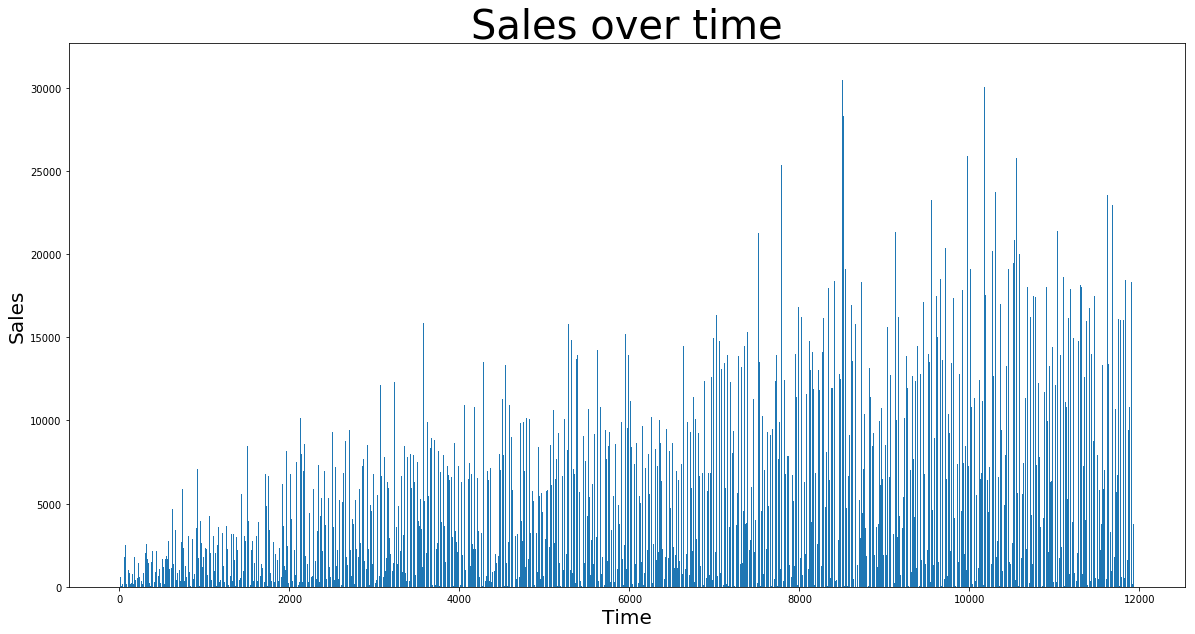

In [8]:
plt.figure(figsize=(20, 10))
plt.bar(range(0,len(sales_granular_original_columns)),(np.sum(sales_granular[sales_granular_original_columns])).values)
plt.xlabel("Time",fontsize=20)
plt.ylabel("Sales",fontsize=20)
plt.title("Sales over time",fontsize=40)

Overall, sales seem to be increasing, but maybe not all stores are doing so well, we must check which ones are performing and which are not. For that we need to create a variable that can summarize performance.

We will use the average sales over time but with two important distinctions:

### 1)
We will use weighted average, giving more importance the recent sales over older ones. The assumption is that we give more credit to a store that has been selling more today than another store that sold the same quantity a year ago.

### 2)
We will divide the weighted average by the number of days that have passed since the first sale of that particular store. This tends to show consistent performance over a store that is not performing well but has been operating for a very long time. The assumption is that the first sale present in the dataset represent the moment the POS started operating

In [9]:
sales_granular["AW_Sales"] = np.average(sales_granular[sales_granular_original_columns],axis=1,weights=np.array(range(0,sales_granular[sales_granular_original_columns].shape[1]))) / timePassed

Lets aggreate the sales to get more intuition about the sales behaviour

In [10]:
#We will use regex in order to get the desired columns
pattern = re.compile("^1/")

In [11]:
for m in range(1,13):
    p = "^"+str(m)+"/"
    pattern = re.compile(p)
    monthColumns = filter(pattern.match,sales_granular.columns)
    sales_granular["Month_"+str(m)] = (np.sum(sales_granular[monthColumns],axis=1))

Text(0.5,1,u'Product seasonality')

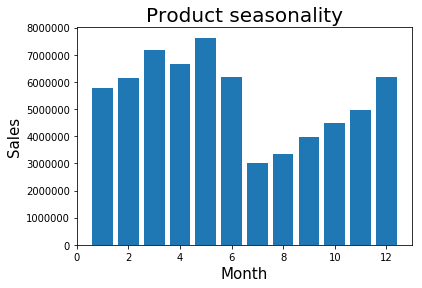

In [12]:
plt.bar(range(1,13),np.sum(sales_granular.iloc[:,-12:]))
plt.xlabel("Month",fontsize=15)
plt.ylabel("Sales",fontsize=15)
plt.title("Product seasonality",fontsize=20)

We can see that the sales are very seasonal, droping during July of the year, recovering in December and staying in the same level untill June.

In [13]:
for d in range(1,32):
    p = "^(.)*/"+str(d)+"/.."
    pattern = re.compile(p)
    dayColumns = filter(pattern.match,sales_granular.columns)
    sales_granular["Day_"+str(d)] = (np.sum(sales_granular[dayColumns],axis=1))

Text(0.5,1,u'Sales during the month')

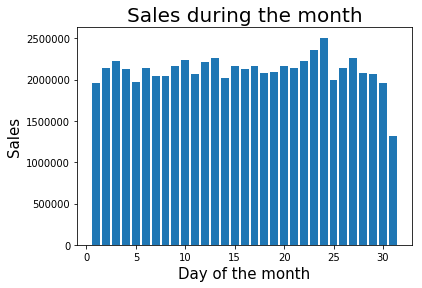

In [14]:
plt.bar(range(1,32),np.sum(sales_granular.iloc[:,-31:]))
plt.xlabel("Day of the month",fontsize=15)
plt.ylabel("Sales",fontsize=15)
plt.title("Sales during the month",fontsize=20)

We don't see much volatility during the month, which leads to believe that the product is not affected by when one receive a salary or not, which often happend by the end of the month.

In [15]:
for h in range(0,24):
    p = "(.)* "+str(h)+":00"
    pattern = re.compile(p)
    hourColumns = filter(pattern.match,sales_granular.columns)
    sales_granular["Hour_"+str(h)+":00"] = (np.sum(sales_granular[hourColumns],axis=1))

Text(0.5,1,u'Sales during the day')

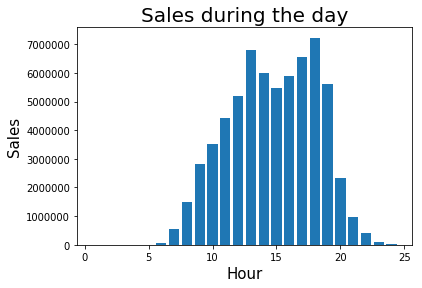

In [16]:
plt.bar(range(1,25),np.sum(sales_granular.iloc[:,-24:]))
plt.xlabel("Hour",fontsize=15)
plt.ylabel("Sales",fontsize=15)
plt.title("Sales during the day",fontsize=20)

The sales of the product varies a lot based on the hour, it peaks in at 13:00 and 18:00. It is possible to imagine that the product must be bought when people are out of the office, in lunch time and when leaving the company.

In [17]:
sales_granular.drop(sales_granular_original_columns,axis = 1, inplace=True)

The other dataset represent the surroundings of the stores. We will subset the data that we are interested in analysing and use a lighter version of the file. 

In [1918]:
with open("Data/UseCase_3_Datasets/Surroundings.json", "r") as f:
  surroundings = json.loads(f.read())

In [1919]:
df = pd.io.json.json_normalize(surroundings)

We will collect, for each POS, the number of each kind surroundings and its respective longitude and latitude.

In [483]:
count = 0
numberOfrows = df.shape[0]
columns = df.columns[1:]
for c in columns:
    for r in range(0,numberOfrows):
        d = df.loc[r,c]
        df.loc[r,c+"_numberOfPoints"] = 0
        if len(d) > 0:
            numberOfPoints = pd.io.json.json_normalize(d).shape[0]
            latitude = pd.io.json.json_normalize(df.loc[r,c]).loc[0,"latitude"]
            longitude = pd.io.json.json_normalize(df.loc[r,c]).loc[0,"longitude"]
            df.loc[r,c+"_latitude"] = latitude
            df.loc[r,c+"_longitude"] = longitude
            df.loc[r,c+"_numberOfPoints"] = numberOfPoints           

surroundings.accounting
surroundings.airport
surroundings.amusement_park
surroundings.aquarium
surroundings.art_gallery
surroundings.atm
surroundings.bakery
surroundings.bank
surroundings.bar
surroundings.beauty_salon
surroundings.bicycle_store
surroundings.book_store
surroundings.bowling_alley
surroundings.bus_station
surroundings.cafe
surroundings.campground
surroundings.car_dealer
surroundings.car_rental
surroundings.car_repair
surroundings.car_wash
surroundings.casino
surroundings.cemetery
surroundings.church
surroundings.city_hall
surroundings.clothing_store
surroundings.convenience_store
surroundings.courthouse
surroundings.dentist
surroundings.department_store
surroundings.doctor
surroundings.electrician
surroundings.electronics_store
surroundings.embassy
surroundings.fire_station
surroundings.florist
surroundings.funeral_home
surroundings.furniture_store
surroundings.gas_station
surroundings.gym
surroundings.hair_care
surroundings.hardware_store
surroundings.hindu_temple
surrou

We save the file that we will be using from now on.

In [484]:
#df.drop(columns, axis=1, inplace=True)
#df.to_csv("Data/UseCase_3_Datasets/Surroundings_formated.csv")

In [18]:
surroundings = pd.read_csv("Data/UseCase_3_Datasets/Surroundings_formated.csv",index_col=0)

In [19]:
surroundings.set_index(surroundings["store_code"].values,inplace=True)
surroundings.drop("store_code", axis=1, inplace=True)

In [20]:
surroundings = surroundings[surroundings.index.duplicated(keep="first") == False]

In [21]:
sales_granular = sales_granular[sales_granular.index.duplicated(keep="first") == False]

We join the two datasets, minding that we will lose many observations since surroundings dataset doesn't have as many observations as granular_sales

In [322]:
data = surroundings.join(sales_granular,how="inner")

We will also create new features:

1) We will sum the quantity of all surroundings per POS in a variable called totalNumberOfPoints

2) Create two features, longitude and latitude, that are the average of the same measured for the surrounding places, this will serve us as a proxy for the location of the POS

In [323]:
p = "(.)*_numberOfPoints"
pattern = re.compile(p)
numberOfPointsColumns = filter(pattern.match,data.columns)

In [324]:
data["totalNumberOfPoints"] = np.sum(data[numberOfPointsColumns],axis=1)
numberOfPointsColumns = numberOfPointsColumns + ["totalNumberOfPoints"]

In [325]:
p = "(.)*_latitude"
p2 = "(.)*_longitude"
pattern = re.compile(p)
pattern2 = re.compile(p2)

latitudeColumns = filter(pattern.match,data.columns)
longitudeColumns = filter(pattern2.match,data.columns)


In [326]:
data["longitude"] = np.mean(data[longitudeColumns],axis=1)
data["latitude"] = np.mean(data[latitudeColumns],axis=1)

In [327]:
data = data[data["longitude"].notnull()]

Plotting our performance variable AW_Sales along with longitude and latitude can give us an intuition if location if relevant for our analysis.

Text(0.5,1,u'POS locations')

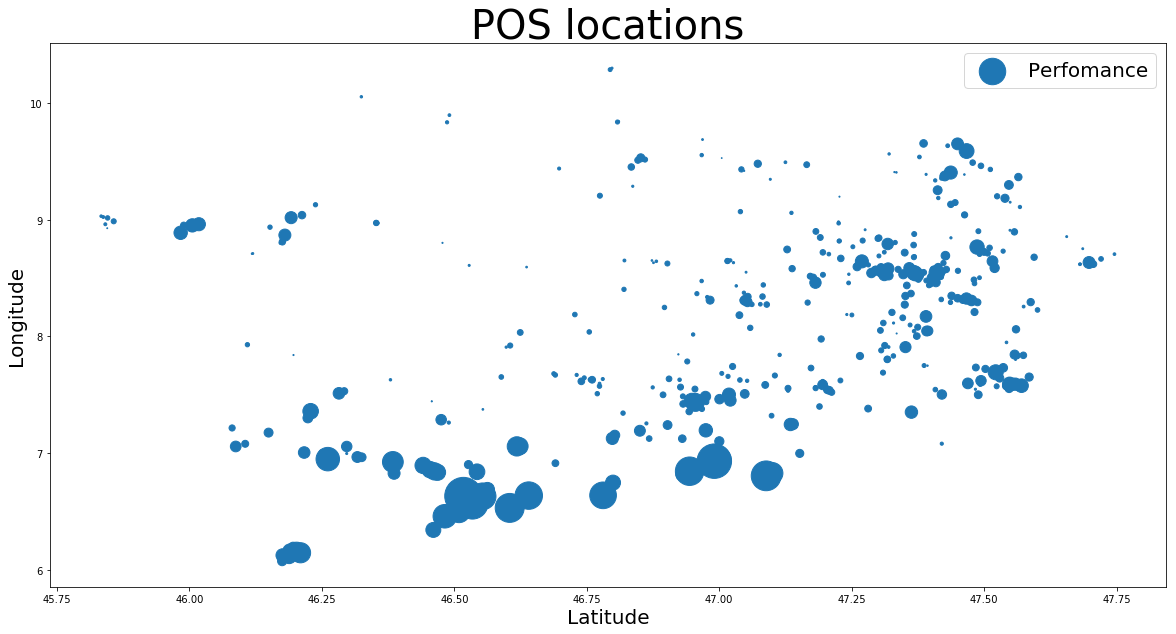

In [328]:
plt.figure(figsize=(20, 10))
plt.scatter(data["latitude"],data["longitude"],s=data["AW_Sales"]*10000)
plt.legend(["Perfomance"],fontsize=20)
plt.xlabel("Latitude",fontsize=20)
plt.ylabel("Longitude",fontsize=20)
plt.title("POS locations",fontsize=40)

Indeed, we can see that high performance is concentrated in some areas in the South the region.

To complement the information provided in surroundings it was created a dataset that is a reference for the kinds of places we have. Even though surroundings.json had a similar information, I believe this classification is simpler and will be more useful to our analysis. Based on this categories 4 new features will be added, they will represent the total number of such kind of places that are nearby.

In [329]:
referenceTable = pd.read_csv("Data/UseCase_3_Datasets/ReferenceTable.csv",sep=";",index_col=False)

In [330]:
services = referenceTable.loc[referenceTable["Type"] == "services","ColumnName"].values
transport = referenceTable.loc[referenceTable["Type"] == "transport","ColumnName"].values
DrinkNEat = referenceTable.loc[referenceTable["Type"] == "DrinkNEat","ColumnName"].values
Store = referenceTable.loc[referenceTable["Type"] == "Store","ColumnName"].values
recreation = referenceTable.loc[referenceTable["Type"] == "recreation","ColumnName"].values

In [331]:
data["services"] = np.sum(data[services],axis=1)
data["transport"] = np.sum(data[transport],axis=1)
data["DrinkNEat"] = np.sum(data[DrinkNEat],axis=1)
data["Store"] = np.sum(data[Store],axis=1)
data["recreation"] = np.sum(data[recreation],axis=1)

Since we saw that location is an important factor, we will clusters using longitude and latitude that will represent places where the POS are located. In order to choose how many clusters, we use silhouette analysis.

In [276]:
silhouette = []
for i in range(2,100):
    kmeans = KMeans(n_clusters=i, random_state=0)
    clusters = kmeans.fit(data[["latitude","longitude"]])
    silhouette.append(silhouette_score(data[["latitude","longitude"]],clusters.labels_))

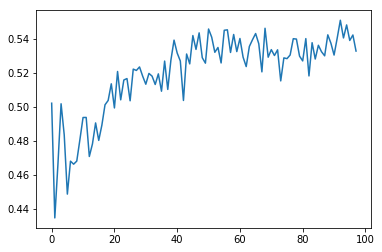

In [277]:
plt.plot(silhouette)

Even though we could pick over 50 clusters, given that we don't many observations, we will limit to 30 to have enough POS per cluster.

In [332]:
nClusters = 30
kmeans = KMeans(n_clusters=nClusters, random_state=0)
clusters = kmeans.fit(data[["latitude","longitude"]])

In [333]:
clustersLabels = clusters.labels_.astype("string")
data["Clusters"] = copy.deepcopy(clustersLabels)

Other feature we can create will be used as a proxy for location density and will be the value of silhouette per cluster. Also we will create a number called POSCount that is the number of POS in a particular cluster

In [280]:
data["silhouette"] = silhouette_samples(data[["latitude","longitude"]],clusters.labels_)

In [281]:
d = pd.DataFrame(data.groupby(["Clusters"])["silhouette"].mean())
unique, counts = np.unique(clustersLabels, return_counts=True)
d = d.join(pd.DataFrame(counts,index=unique,columns=["POSCount"]),how="inner")
d["Clusters"] = d.index
data.drop("silhouette",axis=1,inplace=True)

In [282]:
data = data.merge(d,on=["Clusters"])

In [283]:
data.drop(latitudeColumns+longitudeColumns,axis=1,inplace=True)

We can see the clusters printed on the map bellow

Text(0.5,1,u'POS locations')

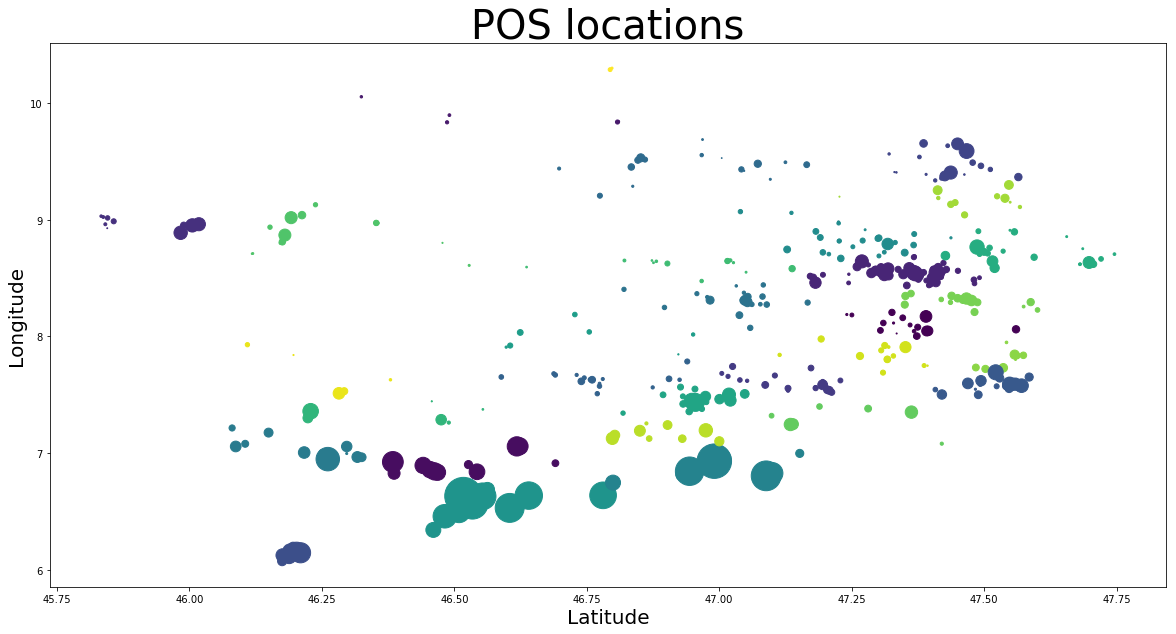

In [284]:
plt.figure(figsize=(20, 10))
plt.scatter(data["latitude"],data["longitude"],c=data["Clusters"],s=data["AW_Sales"]*10000)
plt.xlabel("Latitude",fontsize=20)
plt.ylabel("Longitude",fontsize=20)
plt.title("POS locations",fontsize=40)

We can also check the performance per cluster

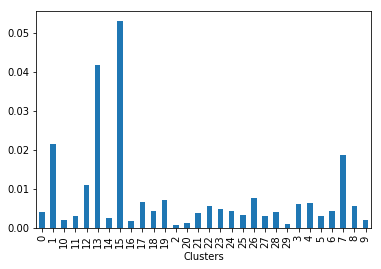

In [285]:
data.groupby(["Clusters"])["AW_Sales"].mean().plot.bar()

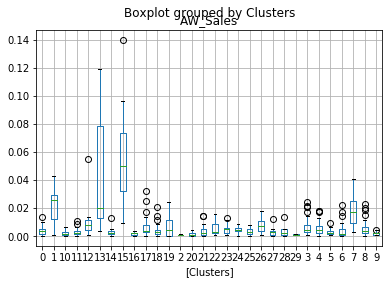

In [286]:
data[["AW_Sales","Clusters"]].boxplot(by="Clusters")

But we can see that we have high variability within each clusters, which means that location is not the only factor to take into account. But lets see which features are the most important considering all clusters at once.

In [287]:
dataWClusters = copy.deepcopy(data)
data = pd.get_dummies(data)

Given the exponential nature of our target variable, we use its log version for processing.

In [288]:
target = np.log(data["AW_Sales"])

In [289]:
X_train, X_test, y_train, y_test = train_test_split(data[numberOfPointsColumns+list(data.columns[-(nClusters+9):])],
                                                    target,test_size=0.30,random_state=0)

In [290]:
regr=RandomForestRegressor(random_state = 0)
regr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)

The error is quite low, even for the small numbers we are dealing with. We can also confirm its performance plotting the true values against the prediction on test set

In [297]:
print mean_squared_error(np.exp(regr.predict(X_test)), np.exp(y_test)) / np.mean(np.exp(y_test))

0.016839170511


In [298]:
np.mean(np.exp(y_test))

0.007813425396734647

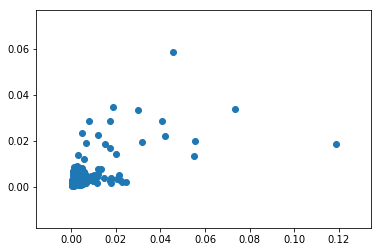

In [252]:
plt.scatter(np.exp(y_test),np.exp(regr.predict(X_test)))

In [253]:
important_features = zip(data[numberOfPointsColumns+list(data.columns[-(nClusters+9):])].columns,regr.feature_importances_)

In [254]:
sorted(important_features, key=lambda tup: tup[1])

[('surroundings.airport_numberOfPoints', 0.0),
 ('surroundings.aquarium_numberOfPoints', 0.0),
 ('surroundings.campground_numberOfPoints', 0.0),
 ('surroundings.casino_numberOfPoints', 0.0),
 ('surroundings.hindu_temple_numberOfPoints', 0.0),
 ('surroundings.movie_rental_numberOfPoints', 0.0),
 ('surroundings.rv_park_numberOfPoints', 0.0),
 ('surroundings.subway_station_numberOfPoints', 0.0),
 ('surroundings.synagogue_numberOfPoints', 0.0),
 ('surroundings.zoo_numberOfPoints', 0.0),
 ('Clusters_12', 0.0),
 ('Clusters_2', 0.0),
 ('Clusters_28', 0.0),
 ('Clusters_29', 0.0),
 ('Clusters_7', 0.0),
 ('Clusters_23', 1.6125424052358961e-06),
 ('surroundings.stadium_numberOfPoints', 3.0166243997595579e-06),
 ('surroundings.courthouse_numberOfPoints', 6.3267933313531414e-06),
 ('Clusters_26', 1.3970580314020419e-05),
 ('surroundings.cemetery_numberOfPoints', 1.7871719609827065e-05),
 ('surroundings.amusement_park_numberOfPoints', 1.8751406421898229e-05),
 ('Clusters_24', 2.3654150116763144e-05)

As we expected the most important features are latitude and longitude are the best predictors for performance. Lets try to visualize the effects of location over sales.

Text(0.5,1,u'Effects of location over performance')

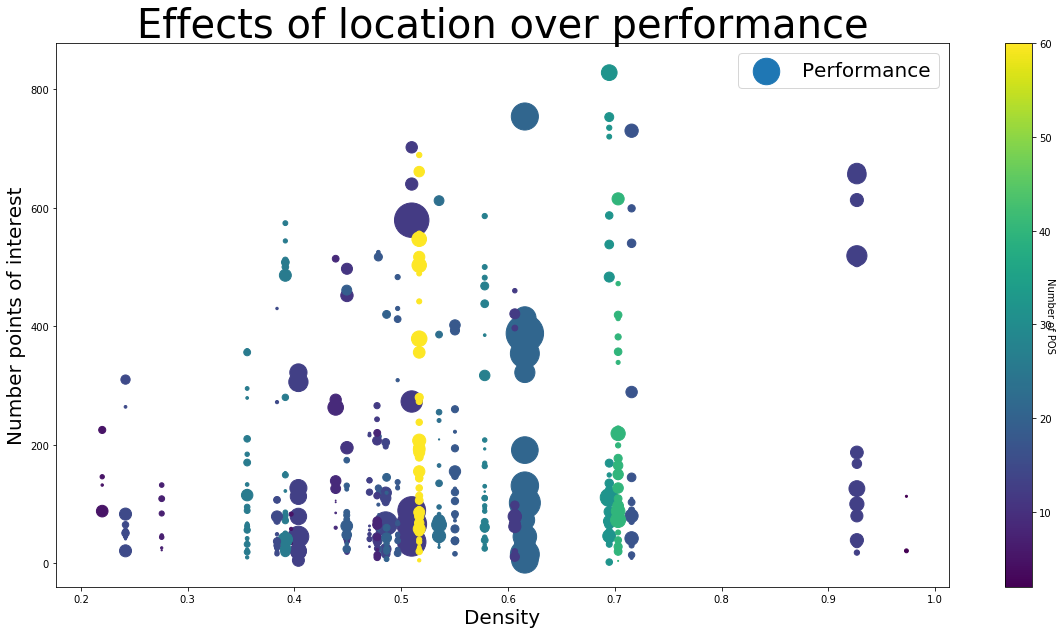

In [255]:
#unique, counts = np.unique(clustersLabels, return_counts=True)
#dict(zip(unique, counts))
plt.figure(figsize=(20, 10))
plt.scatter(data["silhouette"],data["totalNumberOfPoints"],c=data["POSCount"],s=data["AW_Sales"]*10000)
cbar = plt.colorbar(shrink=1)
plt.xlabel("Density",fontsize=20)
plt.ylabel("Number points of interest",fontsize=20)
plt.legend(["Performance"],fontsize=20)
cbar.ax.set_ylabel('Number of POS', rotation=270)
plt.title("Effects of location over performance",fontsize=40)

If we think that totalNumberOfPoints may indicate the size of the city, silhouette its density we can see that we can find higher performances in the middle range of density regardless of size. But we will almost certainly see poor performance if we have a high concentration of POS in the same region. This may be to the fact that the POS are canibalizing each other.

So giving this information, we can understand now that part of the performance is certainly given by the location and city environment, regardless of its surroudings. So now, we will make the same analysis per cluster and check the features that are the most important for each. We will also record the importance value for the top five features in each cluster.

In [257]:
importantSurroundings = []
explanatory = []
for i in range(0,nClusters):
    d = data[data["Clusters_"+str(i)]== 1]
    d.drop(["longitude","latitude"],axis=1,inplace=True)
    target = np.log(d["AW_Sales"])
    X_train, X_test, y_train, y_test = train_test_split(d[numberOfPointsColumns+list(d.columns[-(nClusters+7):])],
                                                        target,test_size=0.0,random_state=0)
    regr=RandomForestRegressor(random_state = 0)
    regr.fit(X_train, y_train)
    important_features = zip(d[numberOfPointsColumns+list(d.columns[-(nClusters+7):])].columns,regr.feature_importances_)
    importantSurroundings.append([sorted(important_features, key=lambda tup: tup[1])[-5][0],
                                  sorted(important_features, key=lambda tup: tup[1])[-4][0],
                                  sorted(important_features, key=lambda tup: tup[1])[-3][0],
                                  sorted(important_features, key=lambda tup: tup[1])[-2][0],
                                  sorted(important_features, key=lambda tup: tup[1])[-1][0]])
    explanatory.append(sorted(important_features, key=lambda tup: tup[1])[-1][1])
    
    

C:\Users\NelsonGuilherme\Anaconda2\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [258]:
f = copy.deepcopy(dataWClusters)

In [259]:
a = pd.DataFrame(f.groupby("Clusters")["totalNumberOfPoints"].mean().sort_values(ascending=False))

In [260]:
ind = a.sort_values("totalNumberOfPoints").index

In [261]:
lowPOSCount = []
highPOSCount = []
toprintexp = []
for i in ind[:-15]:
    toprintexp.append(explanatory[int(i)])
    lowPOSCount = lowPOSCount +importantSurroundings[int(i)]
for i in ind[-15:]:
    toprintexp.append(explanatory[int(i)])
    highPOSCount = highPOSCount +importantSurroundings[int(i)]

In [299]:
hP = pd.Series(highPOSCount).value_counts()

In [302]:
lP = pd.Series(lowPOSCount).value_counts()

We can see that places with more POS the transportation and clothing stores are highly important but for low POS places to eat and drink are a better choice.